# SQL Examples: Joins and Aggregation Queries

This notebook continues my SQL practice with the Chinook database, focusing on combining data from multiple tables and summarizing.

These exercises demonstrate practical use of:

- INNER JOINs to link customer, invoice, and employee data  
- GROUP BY and aggregate functions (COUNT, SUM) to compute metrics such as total revenue or track counts  
- Filtering and sorting results to identify top-performing customers and artists  
- Common Table Expressions (CTEs) to structure multi-step queries and simplify analysis  
- Window Functions (RANK) to compute ranks
- Practical data analysis patterns, such as ranking results, aggregating by category, and summarizing business performance

## Setup

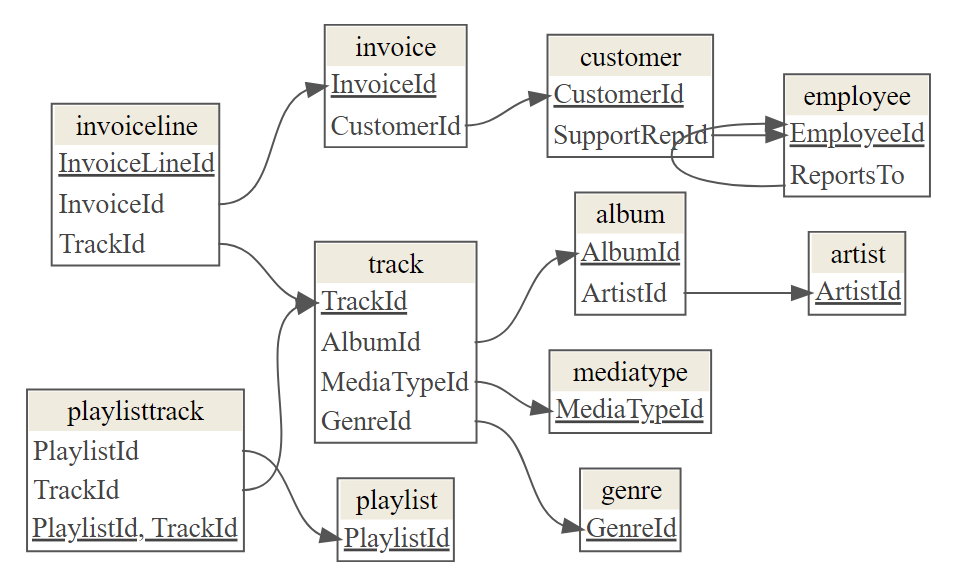

In [1]:
from pathlib import Path
from IPython.display import Image, display
import pandas as pd

# project root
repo_root = Path().resolve().parent  

# database path relative to project root
DB_PATH = repo_root / "data" / "Chinook_Sqlite.sqlite"

assert DB_PATH.exists(), f"Database file not found: {DB_PATH}"

# SQLAlchemy engine
from sqlalchemy import create_engine
engine = create_engine(f"sqlite:///{DB_PATH}")

# image path relative to repo root
image_path = repo_root / "input" / "ChinookDBStructure.png"

# check it exists
assert image_path.exists(), f"Image file not found: {image_path}"

# display
display(Image(filename=str(image_path), width=600, height=400))

---
## Query Examples

### 1) List all invoices with the customer name and total invoice amount.

In [2]:
query = """

SELECT TRIM(c.FirstName || ' ' || c.LastName) as customer_name,
       i.InvoiceId,
       i.Total AS invoice_amount
FROM customer AS c
JOIN invoice AS i ON c.CustomerId = i.CustomerId
ORDER BY customer_name ;

"""
df = pd.read_sql_query(query, engine)
df

,customer_name,InvoiceId,invoice_amount
0,Aaron Mitchell,50,1.98
1,Aaron Mitchell,61,13.86
2,Aaron Mitchell,116,8.91
3,Aaron Mitchell,245,1.98
4,Aaron Mitchell,268,3.96
...,...,...,...
407,Wyatt Girard,83,0.99
408,Wyatt Girard,204,3.98
409,Wyatt Girard,215,13.86
410,Wyatt Girard,270,8.91


### 2) Show total revenue per country.

In [5]:
query = """

SELECT c.Country, -- using customer country
       COALESCE(SUM(i.Total),0) AS total_revenue
FROM customer AS c
JOIN invoice AS i ON c.CustomerId = i.CustomerId
GROUP BY c.Country
ORDER BY total_revenue DESC ;

"""
df = pd.read_sql_query(query, engine)
df

,Country,total_revenue
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48
5,United Kingdom,112.86
6,Czech Republic,90.24
7,Portugal,77.24
8,India,75.26
9,Chile,46.62


### 3) Count the number of tracks each artist has.

In [7]:
query = """

SELECT ar.Name AS artist,
       COUNT(tr.TrackId) AS track_count
FROM artist AS ar
JOIN album AS al ON ar.ArtistId = al.ArtistId
JOIN track AS tr ON al.AlbumId = tr.AlbumId
GROUP BY ar.ArtistId, ar.Name
ORDER BY track_count DESC ;

"""
df = pd.read_sql_query(query, engine)
df

,artist,track_count
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
...,...,...
199,"Mela Tenenbaum, Pro Musica Prague & Richard Kapp",1
200,Emerson String Quartet,1
201,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...",1
202,Nash Ensemble,1


### 4) Find the top 5 customers by total invoice amount.

In [8]:
# LIMIT version

query = """

SELECT TRIM(c.FirstName || ' ' || c.LastName) AS customer_name,
       COALESCE(SUM(i.Total),0) AS total_invoice_amount
FROM customer AS c
JOIN invoice AS i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_invoice_amount DESC
LIMIT 5 ;

"""
df = pd.read_sql_query(query, engine)
df

,customer_name,total_invoice_amount
0,Helena Holý,49.62
1,Richard Cunningham,47.62
2,Luis Rojas,46.62
3,Ladislav Kovács,45.62
4,Hugh O'Reilly,45.62


In [10]:
# CTE version

query = """

WITH ranked_customers AS(

SELECT TRIM(c.FirstName || ' ' || c.LastName) AS customer_name,
       COALESCE(SUM(i.Total),0) AS total_invoice_amount,
       RANK() OVER(ORDER BY COALESCE(SUM(i.Total),0) DESC) AS customer_rank
FROM customer AS c
JOIN invoice AS i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY total_invoice_amount DESC
)
SELECT *
FROM ranked_customers
WHERE customer_rank <= 5
ORDER BY total_invoice_amount DESC;

"""
df = pd.read_sql_query(query, engine)
df

,customer_name,total_invoice_amount,customer_rank
0,Helena Holý,49.62,1
1,Richard Cunningham,47.62,2
2,Luis Rojas,46.62,3
3,Ladislav Kovács,45.62,4
4,Hugh O'Reilly,45.62,4


### 5) List the number of invoices per employee.

In [5]:
query = """

SELECT TRIM(e.FirstName || ' ' || e.LastName) AS employee_name,
       COUNT(i.InvoiceId) AS invoice_count
FROM employee AS e
JOIN customer AS c ON e.EmployeeId = c.SupportRepId
JOIN invoice AS i ON c.CustomerId = i.CustomerId
GROUP BY e.EmployeeId, e.FirstName, e.LastName
ORDER BY employee_name

"""
df = pd.read_sql_query(query, engine)
df

,employee_name,invoice_count
0,Jane Peacock,146
1,Margaret Park,140
2,Steve Johnson,126


### 6) Show total revenue per genre.

In [11]:
query = """

SELECT g.Name AS genre_name,
       COALESCE(SUM(il.UnitPrice * il.Quantity),0) AS total_revenue
FROM genre AS g
JOIN track AS t ON g.GenreId = t.GenreId
JOIN invoiceline AS il ON t.TrackId = il.TrackId
GROUP BY g.GenreId, g.Name
ORDER BY total_revenue DESC

"""
df = pd.read_sql_query(query, engine)
df

,genre_name,total_revenue
0,Rock,826.65
1,Latin,382.14
2,Metal,261.36
3,Alternative & Punk,241.56
4,TV Shows,93.53
5,Jazz,79.20
6,Blues,60.39
7,Drama,57.71
8,R&B/Soul,40.59
9,Classical,40.59


### 7) Find artists with more than 20 tracks in the database.

In [46]:
# LIMIT version

query = """

SELECT ar.Name AS artist_name,
       COUNT(tr.TrackId) AS track_count
FROM artist AS ar
JOIN album AS al ON ar.ArtistId = al.ArtistId
JOIN track AS tr ON al.AlbumId = tr.AlbumId
GROUP BY ar.ArtistId
ORDER BY track_count DESC
LIMIT 55 ; -- manually determine number of rows that have 20+ track counts

"""
df = pd.read_sql_query(query, engine)
df

,artist_name,track_count
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
5,Deep Purple,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


In [45]:
# CTE version
query = """

WITH artist_track_counts AS(
SELECT ar.Name AS artist_name,
       COUNT(tr.TrackId) AS track_count
FROM artist AS ar
JOIN album AS al ON ar.ArtistId = al.ArtistId
JOIN track AS tr ON al.AlbumId = tr.AlbumId
GROUP BY ar.ArtistId
ORDER BY track_count DESC 
)
SELECT *
FROM artist_track_counts
WHERE track_count >= 20 -- filter for artists that have 20+ track counts
ORDER BY track_count DESC ;

"""
df = pd.read_sql_query(query, engine)
df


,artist_name,track_count
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
5,Deep Purple,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53
